# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


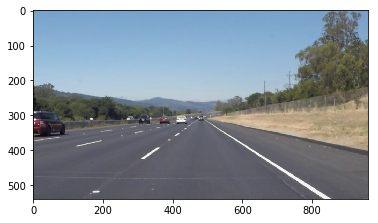

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [31]:
import math

def grayscale_image(image):
    """
        Method used to grayscale an image
        **input: **
            *image: (Numpy ndArray)
        **return: **
            *(Numpy ndArray) GrayScale Image
    """
    grayscale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return grayscale


def blur_image(image, kernel_size=5):
    """
        Method used to blur an image
        **input: **
            *image: (Numpy ndArray)
            *kernel_size: [Optional] (Integer) Size of the kernel
        **return: **
            *(Cv2 Image) Blurred image
    """
    blurred = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
    return blurred


def detect_edges(image, low_threshold=50, high_threshold=150):
    """
        Method used to detect edges in the image
        **input: **
            *image: (Numpy ndArray)
            *low_threshold: [Optional] (Integer) Minimum value
            *high_threshold: [Optional] (Integer) Maximum value
        **return: **
            *(Cv2 Image) Edges detected
    """
    edges = cv2.Canny(image, low_threshold, high_threshold)
    return edges


def square_image_mask(image, config):
    """
        Method used to create a square mask on the image
        **input: **
            *image: (Numpy ndArray)
            *config (Dict with x and y position)
        **return: **
            *(Cv2 Image) Image masked
    """
    mask = np.zeros_like(image)  # Create an image with the same shape filled with zeros
    ignore_mask_color = 255
    shape = image.shape
    # Create the set of points

    config = config.copy()
    # Convert percentage data to real position point
    config["top_x_left"] = int(config["top_x_left"] * shape[1])
    config["top_x_right"] = int(shape[1] - (config["top_x_right"] * shape[1]))
    config["bot_x_left"] = int(config["bot_x_left"] * shape[1])
    config["bot_x_right"] = int(shape[1]  - (config["bot_x_right"] * shape[1]))

    config["top_y_left"] = int(config["top_y_left"] * shape[0])
    config["top_y_right"] = int(config["top_y_right"] * shape[0])
    config["bot_y_left"] = int(shape[0] - (config["bot_y_left"] * shape[0]))
    config["bot_y_right"] = int(shape[0] - (config["bot_y_right"] * shape[0]))

    mask_array = [[
        (config["bot_x_left"], config["bot_y_left"]),  # Bottom left point
        (config["top_x_left"], config["top_y_left"]),  # Top left point
        (config["top_x_right"], config["top_y_right"]),  # Top right point
        (config["bot_x_right"], config["bot_y_right"])  # Bottom right point
    ]]
    
    # Convert the mask to a numpy array
    vertices = np.array(mask_array, dtype=np.int32)
    # Pixel outside of the polygone will be turn in white (255)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    # Apply mask to the original image
    
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def lines_to_main_line(original_image, lines_clusters, min_y):
    """
        Method used to create two main line from all little lines.
        **input: **
            *original_image: (Numpy ndArray) Image used to draw line on
            *lines_clusters: (2dim Array) [0] stored lines on the left, [1] on the right
            *min_y: (Integer) minimum y value
        **return: **
            *(Numpy image) New image
    """
    # The two main line will first be drawn on this mask
    mask = np.zeros(original_image.shape, np.uint8)
    # Go through all lines segments
    for cluster in lines_clusters:
        try:
            cluster = np.array(cluster)
            # Sort lines. (From the top of the image to the bottom)
            cluster = cluster[cluster[:,1].argsort()]
            # Extract x, y values
            x_points = cluster[:,0]
            y_points = cluster[:,1]
            # Get the slope of the line (given the point bottom point and the top point)
            slope = float(y_points[0] - y_points[-1]) / float(x_points[0] - x_points[-1])
            # Compute the intercept of the line
            intercept = y_points[0] - (slope * x_points[0])
            # Now, we need two new points to draw the main line
            # y = mx + b | x = (y - b) / m
            pt2_x = int(float(min_y - intercept) / float(slope))
            pt1_x = int(float(original_image.shape[0] - intercept) / float(slope))
            # Set the two points
            pt1 = (pt1_x, int(original_image.shape[0]))
            pt2 = (pt2_x, int(min_y))
            # Draw the new line
            cv2.line(mask, pt1, pt2, (255, 0, 0), 15)
        except Exception as e: # One of the two line can't be draw
            pass
    # Return the new image
    return weighted_img(mask, original_image)
    

def hough_detector(image, original_image, config, slope_filter=True, simple_line=True):
    """
        Method used to detect lines on grayScale image
        **input: **
            *image: (Numpy ndArray) GrayScale image used to detect line
            *original_image: (Numpy ndArray) Image used to draw line on
            *config: Dict with hough parameters
            *slope_filter: Used to select only lines with a slope > config["slope_threshold"]
            *simple_line: Used to replace littles lines with one main red line for each line of the road.
        **return: (Tuple) **
            *(2dim Array) Array with all detected lines
            *(Numpy image) New image
    """
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(image, config["rho"], np.pi / config["degree"], config["threshold"], np.array([]), config["min_line_length"], config["max_line_gap"])
    positive = lambda x: x * -1 if x < 0 else x
    # Lambda function used to translate one position from the analyzed image  (smaller) to 
    # the position of the original image.
    x_to_original = lambda x: int(float(x) / float(image.shape[1]) * float(original_image.shape[1]))
    y_to_original = lambda y: int(float(y) / float(image.shape[0]) * float(original_image.shape[0]))
    # Used to sort lines (from the left of the road or from the right)
    lines_clusters = [[], []]
    # Variables used to keep in memory the minimum y value. 
    min_y = None
    for line in lines:
        for x1, y1, x2, y2 in line:
            # Horizontal lines are not interesting
            if x2 - x1 == 0.:
                continue
            # Line used to compute the slope of the line
            line_slope = positive(float(y2 - y1) / float(x2 - x1))
            # Only line with a slope > config["slope_threshold"] are drawn.
            pt1, pt2 = None, None
            if line_slope >= config["slope_threshold"] or not slope_filter:
                # Set the value of the two new points used to create the line
                pt1 = (x_to_original(x1), y_to_original(y1))
                pt2 = (x_to_original(x2), y_to_original(y2))
                if min_y is None:
                    min_y = y1
                min_y = min(min(min_y, y2), y1) # Keep in memory the minimum y value
                # If thoses this line is on the left of the image
                if np.mean([pt1[0], pt2[0]]) < original_image.shape[1] / 2:
                    lines_clusters[0].append(pt1)
                    lines_clusters[0].append(pt2)
                else: # On the right
                    lines_clusters[1].append(pt1)
                    lines_clusters[1].append(pt2)
            if not simple_line and pt1 is not None and pt2 is not None:
                # Draw the little line
                cv2.line(original_image, pt1, pt2, (255, 0, 0), 3)
    if simple_line:
        # Convert littles lines into two main lines.
        original_image = lines_to_main_line(original_image, lines_clusters, min_y)
    return line, original_image




## Test Images


Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'Screenshot from 2017-10-08 12-53-38.png',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
config = {
    "kernel_size": 5,
    "edges": {
        "low_threshold": 80,
        "high_threshold": 140
    },
    "mask": {
        "top_x_left": 0.39,
        "top_x_right": 0.39,
        "bot_x_left": 0.05,
        "bot_x_right": 0.05,
        "top_y_left": 0.65,
        "top_y_right": 0.65,
        "bot_y_left": 0.,
        "bot_y_right": 0.
    },
    "hough_transform": {
        "slope_threshold": 0.3,
        "rho" : 10,
        "degree": 180,
        "threshold": 100,
        "min_line_length": 30,
        "max_line_gap": 60
    }
}

In [18]:
def detect_lines(original_image, show=False, show_step=False, enhence_edges=True, slope_filter=True, simple_line=True):
    """
        Method used to detect and add lines to the images
        **input: **
            *image (2dim Array)
            *show (Boolean) Used to show the final image
            *show_step (Boolean) Used to show the final step
            *enhence_edges (Boolean) Used to combined the color selection with the edges detection
            *slope_filter (Boolean) Used to remove liens with a bad slope
            *simple_line: Used to replace littles lines with one main red line for each line of the road.
        **return: **
            *(2dim Array) The same images with lines
    """
    image = cv2.resize(original_image, (960, 540), interpolation = cv2.INTER_CUBIC)
    original_image = cv2.resize(original_image, (960, 540), interpolation = cv2.INTER_CUBIC)
    # Show step
    if show_step:
        plt.imshow(image, cmap='Greys_r')
        plt.show()
    # Yellow mask
    yellow_mask = cv2.inRange(image,  np.array([170, 170, 0]), np.array([255, 255, 150]))
    # Show step
    if show_step:
        plt.imshow(yellow_mask, cmap='Greys_r')
        plt.show()
    # White mask
    white_mask = cv2.inRange(image,  np.array([190, 190, 190]), np.array([255, 255, 255]))
    # Show step
    if show_step:
        plt.imshow(white_mask, cmap='Greys_r')
        plt.show()
    # Grayscale the image
    image = grayscale_image(image)
    # Apply Gaussian smoothing
    image = blur_image(image=image, kernel_size=config["kernel_size"])
    # Used Canny edges detector algorithms to detect edges
    # Show step
    if show_step:
        plt.imshow(image, cmap='Greys_r')
        plt.show()
    edges = detect_edges(image=image, **config["edges"])
    # Show edges detection
    if show_step:
        plt.imshow(edges, cmap='Greys_r')
        plt.show()
    # Enhence edges with color detection
    if enhence_edges:
        edges_white = weighted_img(white_mask, edges)
        edges = weighted_img(yellow_mask, edges_white)
    # Show edges with color mask
    if show_step:
        plt.imshow(edges, cmap='Greys_r')
        plt.show()
    # Mask the edges to keep only a sub part
    edges_masked = square_image_mask(edges, config=config["mask"])
    # Show eges with area mask
    if show_step:
        plt.imshow(edges_masked, cmap='Greys_r')
        plt.show()
    ## Line detector using Hough detector algorithm
    lines, line_image = hough_detector(edges_masked, np.copy(original_image), config["hough_transform"], slope_filter=slope_filter, simple_line=simple_line)
    # Show the final image
    if show:
        plt.imshow(line_image, cmap='Greys_r', label="test")
        plt.show()

    return line_image

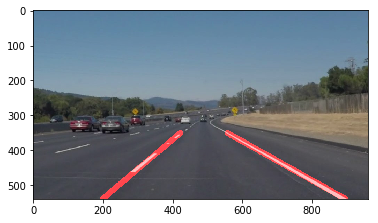

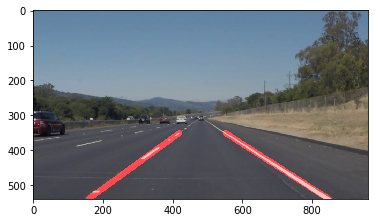

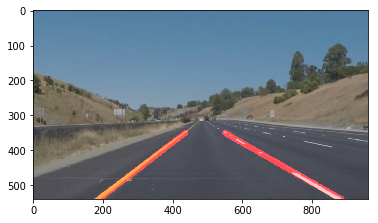

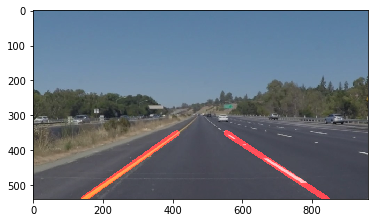

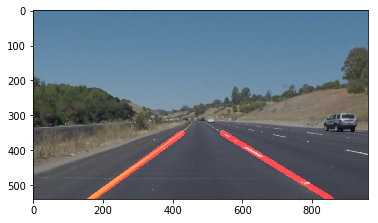

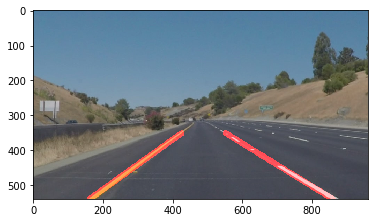

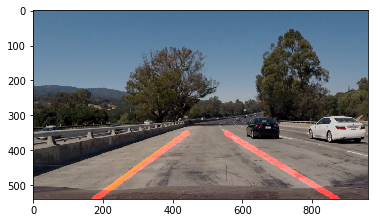

In [37]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

for path in os.listdir("test_images/"):
    # Path to the image to open
    image_path = os.path.join("test_images/", path)
    # Read in and grayscale the image
    original_image = mpimg.imread(image_path)
    # Detect lines
    line_image = detect_lines(original_image, show=True, show_step=False, enhence_edges=True, slope_filter=True, simple_line=True)
    # Write the new image to the test_images directory. Each jpf name is rename with the subname : with_lines_
    #cv2.imwrite(os.path.join("test_images/", "with_lines_%s" % path), line_image, cv2.BGR2RGB)

  
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [26]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    return detect_lines(image)

Let's try the one with the solid white lane on the right first ...

In [27]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:06<00:00, 34.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 36.4 s, sys: 240 ms, total: 36.6 s
Wall time: 6.75 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [29]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:21<00:00, 31.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 1min 52s, sys: 496 ms, total: 1min 52s
Wall time: 21.9 s


In [30]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [33]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:12<00:00, 19.60it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min 18s, sys: 348 ms, total: 1min 18s
Wall time: 13.2 s


In [32]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))